In [85]:
from __future__ import print_function
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.onnx

import torchvision
from torchvision import transforms, datasets, models

import onnx

import helper

from collections import OrderedDict

import numpy as np
import timeit
import glob
import matplotlib.pyplot as plt
from PIL import Image

## Switching from ND Array > Pytorch Tensor -> ND Array

In [6]:
randomArray = np.random.randn(5, 3)
randomArray

array([[-1.15830809,  0.49762122,  0.09137921],
       [-2.3819232 ,  0.47606143, -1.99124683],
       [-1.69857664,  0.14952153, -0.05160555],
       [ 0.0166688 ,  0.89088917, -0.47966096],
       [ 0.16908941,  1.43305621, -0.83057521]])

In [7]:
randomTensor = torch.from_numpy(randomArray)
randomTensor

tensor([[-1.1583,  0.4976,  0.0914],
        [-2.3819,  0.4761, -1.9912],
        [-1.6986,  0.1495, -0.0516],
        [ 0.0167,  0.8909, -0.4797],
        [ 0.1691,  1.4331, -0.8306]], dtype=torch.float64)

In [8]:
randomTensor.numpy()

array([[-1.15830809,  0.49762122,  0.09137921],
       [-2.3819232 ,  0.47606143, -1.99124683],
       [-1.69857664,  0.14952153, -0.05160555],
       [ 0.0166688 ,  0.89088917, -0.47966096],
       [ 0.16908941,  1.43305621, -0.83057521]])

# Switching from using CPU - GPU


In [9]:
cpu = torch.device('cpu')
cuda = torch.device('cuda')

In [ ]:
cuda_0 = torch.device('cuda:0')
cuda_2 = torch.device('cuda:2')

In [14]:
w1 = torch.rand(10000, 10000, device=cpu)
x1 = torch.rand(10000, 10000, device=cpu)

In [21]:
start_cpu = timeit.default_timer()

x1.matmul(w1)

end_cpu = timeit.default_timer()
print('Timelapse: ', end_cpu- start_cpu)

Timelapse:  9.464088493827148


In [22]:
start_gpu = timeit.default_timer()

x1 = x1.cuda()
w1 = w1.cuda()

x1.matmul(w1)

end_gpu = timeit.default_timer()
print('Timelapse: ', end_gpu - start_gpu)

Timelapse:  0.5371105185184888


In [30]:
print('Difference: ', np.round((end_cpu- start_cpu)/(end_gpu - start_gpu), 0),'x faster')

Difference:  18.0 x faster


# Calculate the gradient

In [3]:
# By default, requires_grad is set to False
x = torch.randn(5, 5)
y = torch.randn(5, 5)
z = torch.randn((5, 5), requires_grad=True)

result = x + y
print(result.requires_grad)

second_result = result + z
print(second_result.requires_grad)

False
True


In [ ]:
input = Variable(torch.ones(2, 2), requires_grad=True)
print("Before: ", input.grad)

output = input.mean()
output.backward()

print("After: ", input.grad)

#  Object Oriented Programming Style

In [7]:
input_size = 784
hidden_size = [128, 64]
output_size = 10

In [14]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [16]:
oop_model = Network(input_size=input_size, 
                    hidden_size=hidden_size, 
                    output_size=output_size)
oop_model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

By default, weights and bias are automatically filled up

In [17]:
print(oop_model.fc1.weight)
print(oop_model.fc1.bias)

Parameter containing:
tensor([[ 0.0334,  0.0349,  0.0099,  ...,  0.0143, -0.0273, -0.0090],
        [-0.0218, -0.0161, -0.0073,  ..., -0.0026,  0.0082,  0.0172],
        [ 0.0113, -0.0095,  0.0001,  ..., -0.0025, -0.0066,  0.0297],
        ...,
        [ 0.0303,  0.0197,  0.0251,  ...,  0.0280, -0.0012,  0.0355],
        [ 0.0238, -0.0035,  0.0249,  ..., -0.0151,  0.0099, -0.0339],
        [-0.0237, -0.0225,  0.0079,  ...,  0.0066,  0.0294,  0.0161]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0317,  0.0100, -0.0192, -0.0028, -0.0024,  0.0003,  0.0218,  0.0340,
         0.0087, -0.0174,  0.0250, -0.0033, -0.0197,  0.0130, -0.0136,  0.0229,
        -0.0150, -0.0104, -0.0188,  0.0048, -0.0349, -0.0313,  0.0147,  0.0038,
         0.0222,  0.0204,  0.0070, -0.0352,  0.0320, -0.0268,  0.0100, -0.0078,
         0.0132,  0.0146, -0.0053,  0.0245,  0.0085,  0.0227, -0.0203,  0.0186,
        -0.0038, -0.0208, -0.0135,  0.0206,  0.0192, -0.0245,  0.0148, -0.0251,
        -0.0025

We can also modify the value of these tensors

In [18]:
# Set bias to be zero
oop_model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [19]:
# Set weight into normal distribution with standard deviation of .01
oop_model.fc1.weight.data.normal_(std=.01)

tensor([[ 0.0069, -0.0008, -0.0109,  ..., -0.0039,  0.0123, -0.0008],
        [-0.0027,  0.0198, -0.0050,  ...,  0.0021,  0.0011, -0.0044],
        [ 0.0034,  0.0233,  0.0141,  ...,  0.0094, -0.0049,  0.0153],
        ...,
        [-0.0195,  0.0073,  0.0061,  ...,  0.0207, -0.0077, -0.0110],
        [-0.0055,  0.0001, -0.0076,  ...,  0.0099,  0.0087,  0.0060],
        [-0.0041, -0.0229,  0.0102,  ..., -0.0013,  0.0103,  0.0014]])

# Sequential Style

In [21]:
sequential_model = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_size[0]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[0], out_features=hidden_size[1]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[1], out_features=output_size),
                                 nn.Softmax(dim=1))

sequential_model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)

# Sequential Style - Alternative

In [28]:
alt_sequential_model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_size[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
    ('relu2', nn.ReLU()),
    ('output', nn.Linear(hidden_size[1], output_size)),
    ('softmax', nn.Softmax(dim=1))
]))

alt_sequential_model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

We can pick up any layer easily like you used to code in Python

In [29]:
print(sequential_model[0])
print(sequential_model[1])

print(oop_model.fc1)
print(oop_model.fc2)

print(alt_sequential_model.fc2)
print(alt_sequential_model.relu1)

Linear(in_features=784, out_features=128, bias=True)
ReLU()
Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=128, out_features=64, bias=True)
ReLU()


# Autograd

In [167]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [168]:
input_size = 784
output_size = 10
hidden_layers = [512, 256, 128]

In [169]:
model = helper.Network(input_size, output_size, hidden_layers)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device)

Device: cuda..  Epoch: 1/5..  Training Loss: 2.187..  Test Loss: 1.871..  Test Accuracy: 0.411
Device: cuda..  Epoch: 1/5..  Training Loss: 3.657..  Test Loss: 1.150..  Test Accuracy: 0.581
Device: cuda..  Epoch: 1/5..  Training Loss: 4.686..  Test Loss: 0.940..  Test Accuracy: 0.648
Device: cuda..  Epoch: 1/5..  Training Loss: 5.562..  Test Loss: 0.800..  Test Accuracy: 0.681
Device: cuda..  Epoch: 1/5..  Training Loss: 6.280..  Test Loss: 0.727..  Test Accuracy: 0.742
Device: cuda..  Epoch: 1/5..  Training Loss: 6.972..  Test Loss: 0.699..  Test Accuracy: 0.736
Device: cuda..  Epoch: 1/5..  Training Loss: 7.710..  Test Loss: 0.740..  Test Accuracy: 0.696
Device: cuda..  Epoch: 1/5..  Training Loss: 8.367..  Test Loss: 0.655..  Test Accuracy: 0.756
Device: cuda..  Epoch: 1/5..  Training Loss: 9.015..  Test Loss: 0.608..  Test Accuracy: 0.767
Device: cuda..  Epoch: 1/5..  Training Loss: 9.603..  Test Loss: 0.660..  Test Accuracy: 0.753
Device: cuda..  Epoch: 1/5..  Training Loss: 10.25

Device: cuda..  Epoch: 1/5..  Training Loss: 46.101..  Test Loss: 0.443..  Test Accuracy: 0.837
Device: cuda..  Epoch: 1/5..  Training Loss: 46.499..  Test Loss: 0.459..  Test Accuracy: 0.828
Device: cuda..  Epoch: 1/5..  Training Loss: 46.892..  Test Loss: 0.432..  Test Accuracy: 0.842
Device: cuda..  Epoch: 1/5..  Training Loss: 47.291..  Test Loss: 0.444..  Test Accuracy: 0.835
Device: cuda..  Epoch: 1/5..  Training Loss: 47.700..  Test Loss: 0.411..  Test Accuracy: 0.851
Device: cuda..  Epoch: 1/5..  Training Loss: 48.076..  Test Loss: 0.447..  Test Accuracy: 0.836
Device: cuda..  Epoch: 1/5..  Training Loss: 48.501..  Test Loss: 0.432..  Test Accuracy: 0.837
Device: cuda..  Epoch: 1/5..  Training Loss: 48.906..  Test Loss: 0.425..  Test Accuracy: 0.846
Device: cuda..  Epoch: 2/5..  Training Loss: 49.400..  Test Loss: 0.420..  Test Accuracy: 0.847
Device: cuda..  Epoch: 2/5..  Training Loss: 49.788..  Test Loss: 0.430..  Test Accuracy: 0.844
Device: cuda..  Epoch: 2/5..  Training L

Device: cuda..  Epoch: 2/5..  Training Loss: 78.180..  Test Loss: 0.402..  Test Accuracy: 0.851
Device: cuda..  Epoch: 2/5..  Training Loss: 78.600..  Test Loss: 0.399..  Test Accuracy: 0.854
Device: cuda..  Epoch: 2/5..  Training Loss: 78.981..  Test Loss: 0.402..  Test Accuracy: 0.855
Device: cuda..  Epoch: 2/5..  Training Loss: 79.355..  Test Loss: 0.399..  Test Accuracy: 0.851
Device: cuda..  Epoch: 2/5..  Training Loss: 79.722..  Test Loss: 0.443..  Test Accuracy: 0.840
Device: cuda..  Epoch: 2/5..  Training Loss: 80.124..  Test Loss: 0.407..  Test Accuracy: 0.849
Device: cuda..  Epoch: 2/5..  Training Loss: 80.475..  Test Loss: 0.390..  Test Accuracy: 0.859
Device: cuda..  Epoch: 2/5..  Training Loss: 80.817..  Test Loss: 0.412..  Test Accuracy: 0.844
Device: cuda..  Epoch: 2/5..  Training Loss: 81.187..  Test Loss: 0.389..  Test Accuracy: 0.859
Device: cuda..  Epoch: 2/5..  Training Loss: 81.529..  Test Loss: 0.386..  Test Accuracy: 0.860
Device: cuda..  Epoch: 2/5..  Training L

Device: cuda..  Epoch: 3/5..  Training Loss: 107.585..  Test Loss: 0.376..  Test Accuracy: 0.861
Device: cuda..  Epoch: 3/5..  Training Loss: 107.930..  Test Loss: 0.379..  Test Accuracy: 0.861
Device: cuda..  Epoch: 3/5..  Training Loss: 108.269..  Test Loss: 0.371..  Test Accuracy: 0.865
Device: cuda..  Epoch: 3/5..  Training Loss: 108.603..  Test Loss: 0.376..  Test Accuracy: 0.866
Device: cuda..  Epoch: 3/5..  Training Loss: 108.919..  Test Loss: 0.376..  Test Accuracy: 0.868
Device: cuda..  Epoch: 3/5..  Training Loss: 109.272..  Test Loss: 0.411..  Test Accuracy: 0.849
Device: cuda..  Epoch: 3/5..  Training Loss: 109.577..  Test Loss: 0.383..  Test Accuracy: 0.865
Device: cuda..  Epoch: 3/5..  Training Loss: 109.912..  Test Loss: 0.378..  Test Accuracy: 0.863
Device: cuda..  Epoch: 3/5..  Training Loss: 110.248..  Test Loss: 0.371..  Test Accuracy: 0.864
Device: cuda..  Epoch: 3/5..  Training Loss: 110.581..  Test Loss: 0.435..  Test Accuracy: 0.848
Device: cuda..  Epoch: 3/5..  

Device: cuda..  Epoch: 4/5..  Training Loss: 134.314..  Test Loss: 0.404..  Test Accuracy: 0.853
Device: cuda..  Epoch: 4/5..  Training Loss: 134.658..  Test Loss: 0.396..  Test Accuracy: 0.858
Device: cuda..  Epoch: 4/5..  Training Loss: 134.930..  Test Loss: 0.370..  Test Accuracy: 0.865
Device: cuda..  Epoch: 4/5..  Training Loss: 135.233..  Test Loss: 0.357..  Test Accuracy: 0.870
Device: cuda..  Epoch: 4/5..  Training Loss: 135.558..  Test Loss: 0.356..  Test Accuracy: 0.870
Device: cuda..  Epoch: 4/5..  Training Loss: 135.908..  Test Loss: 0.369..  Test Accuracy: 0.864
Device: cuda..  Epoch: 4/5..  Training Loss: 136.242..  Test Loss: 0.390..  Test Accuracy: 0.855
Device: cuda..  Epoch: 4/5..  Training Loss: 136.538..  Test Loss: 0.371..  Test Accuracy: 0.863
Device: cuda..  Epoch: 4/5..  Training Loss: 136.858..  Test Loss: 0.386..  Test Accuracy: 0.862
Device: cuda..  Epoch: 4/5..  Training Loss: 137.146..  Test Loss: 0.413..  Test Accuracy: 0.856
Device: cuda..  Epoch: 4/5..  

Device: cuda..  Epoch: 5/5..  Training Loss: 159.581..  Test Loss: 0.353..  Test Accuracy: 0.876
Device: cuda..  Epoch: 5/5..  Training Loss: 159.829..  Test Loss: 0.375..  Test Accuracy: 0.870
Device: cuda..  Epoch: 5/5..  Training Loss: 160.138..  Test Loss: 0.364..  Test Accuracy: 0.873
Device: cuda..  Epoch: 5/5..  Training Loss: 160.377..  Test Loss: 0.369..  Test Accuracy: 0.868
Device: cuda..  Epoch: 5/5..  Training Loss: 160.653..  Test Loss: 0.363..  Test Accuracy: 0.866
Device: cuda..  Epoch: 5/5..  Training Loss: 160.938..  Test Loss: 0.363..  Test Accuracy: 0.873
Device: cuda..  Epoch: 5/5..  Training Loss: 161.286..  Test Loss: 0.348..  Test Accuracy: 0.872
Device: cuda..  Epoch: 5/5..  Training Loss: 161.585..  Test Loss: 0.360..  Test Accuracy: 0.865
Device: cuda..  Epoch: 5/5..  Training Loss: 161.909..  Test Loss: 0.347..  Test Accuracy: 0.874
Device: cuda..  Epoch: 5/5..  Training Loss: 162.167..  Test Loss: 0.356..  Test Accuracy: 0.876
Device: cuda..  Epoch: 5/5..  

# Save Model

In [45]:
checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'mymodel.pth')

# Load Model

In [46]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

print(model)

Network(
  (fc): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


# Finetuning by Using Pre-trained Model

In [121]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

d:\programs\anaconda3\envs\deep-learning\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [122]:
data_dir = 'Cat_Dog_data/'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


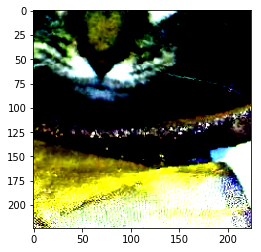

In [130]:
image, label = next(iter(trainloader))
plt.imshow(image[0].numpy().transpose((1, 2, 0)))
print(image[0].shape)

In [81]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device, epochs=1, isTransfer=True)

Device: cuda..  Epoch: 1/1..  Training Loss: 0.278..  Test Loss: 0.167..  Test Accuracy: 0.932
Device: cuda..  Epoch: 1/1..  Training Loss: 0.477..  Test Loss: 0.073..  Test Accuracy: 0.975
Device: cuda..  Epoch: 1/1..  Training Loss: 0.640..  Test Loss: 0.056..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 0.792..  Test Loss: 0.091..  Test Accuracy: 0.969
Device: cuda..  Epoch: 1/1..  Training Loss: 0.969..  Test Loss: 0.050..  Test Accuracy: 0.983
Device: cuda..  Epoch: 1/1..  Training Loss: 1.134..  Test Loss: 0.066..  Test Accuracy: 0.976
Device: cuda..  Epoch: 1/1..  Training Loss: 1.301..  Test Loss: 0.075..  Test Accuracy: 0.975
Device: cuda..  Epoch: 1/1..  Training Loss: 1.391..  Test Loss: 0.054..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 1.529..  Test Loss: 0.055..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 1.651..  Test Loss: 0.056..  Test Accuracy: 0.978
Device: cuda..  Epoch: 1/1..  Training Loss: 1.787

# Convert from Pytorch to another framework by using ONNX

In [171]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

# Export
dummy_input = Variable(torch.randn(1, 784, requires_grad=True))
torch.onnx.export(model, dummy_input, 'first_export.onnx')

#Import 
onnx_model = onnx.load('first_export.onnx')

# Vaidate imported model
onnx.checker.check_model(model)
onnx.helper.printable_graph(model.graph)

AttributeError: 'Network' object has no attribute 'SerializeToString'